In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

import cv2

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, Dropout, MaxPooling2D, Activation,
    Flatten, Dense, Input, Concatenate, LeakyReLU, Add, AveragePooling2D, ReLU, MaxPool2D, ZeroPadding2D,
    AveragePooling2D, Reshape
)
from tensorflow.keras import initializers, regularizers, metrics

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# 앞면 이미지 불러오기
image_front = []
for i in range(1,23224):
    try:
        img1 = cv2.imread('../pill_bbox5/pillbox_{}_0.jpg'.format(i), cv2.IMREAD_COLOR)
        dst1  = cv2.resize(img1, dsize=(224, 224), interpolation=cv2.INTER_AREA)
        image_front.append(dst1)
    except:
        continue

In [3]:
# 뒷면 이미지 불러오기
image_back = []
for i in range(1,23224):
    try:
        img2 = cv2.imread('../pill_bbox5/pillbox_{}_1.jpg'.format(i), cv2.IMREAD_COLOR)
        dst2  = cv2.resize(img2, dsize=(224, 224), interpolation=cv2.INTER_AREA)
        image_back.append(dst2)
    except:
        continue

In [76]:
# 데이터 확인 (보간법 잘 적용되었는지)
cv2.imshow('a',image_front[114])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [4]:
print('front data length : ' + str(len(image_front)))
print('back data length : ' + str(len(image_back)))
print('whole data length : ' + str(len(image_front)+len(image_back)))

front data length : 9111
back data length : 9059
whole data length : 18170


In [5]:
# 약물 index 가져오기
pill_name = os.listdir("../pill_bbox5")
fpill_index = []
for name in pill_name:
    if name.split('_')[2].split('.')[0] == '0':
        fpill_index.append(int(name.split('_')[1]))

In [6]:
bpill_index = []
for name in pill_name:
    if name.split('_')[2].split('.')[0] == '1':
        bpill_index.append(int(name.split('_')[1]))

In [7]:
fpill_index = sorted(fpill_index)
bpill_index = sorted(bpill_index)

In [8]:
print('front data length : ' + str(len(fpill_index)))
print('back data length : ' + str(len(bpill_index)))
print('whole data length : ' + str(len(fpill_index)+len(bpill_index)))

front data length : 9111
back data length : 9059
whole data length : 18170


In [9]:
# 예측 변수 레이블링
data = pd.read_csv('c:/users/student/pill/data.csv')

front_label = list(data[['분류명']].loc[fpill_index].reset_index()['분류명'])
back_label = list(data[['분류명']].loc[bpill_index].reset_index()['분류명'])

In [10]:
# X data, y data 만들기

X_data = np.array(image_front + image_back)
y_data = np.array(front_label + back_label)

print('X data shape = ' + str(X_data.shape))
print('y data shape = ' + str(y_data.shape))

X data shape = (18170, 224, 224, 3)
y data shape = (18170,)


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54792 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 50517 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54616 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 51228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 54644 missing from c

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 51200 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 50896 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 52649 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 45516 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 54588 missing from current fon

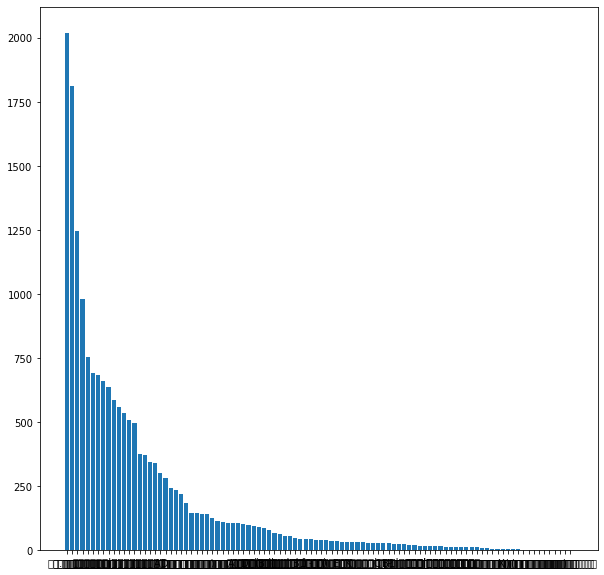

In [11]:
# 데이터 분포 확인

y_dataframe = pd.DataFrame(y_data)

plt.figure(figsize=(10,10))
plt.bar(y_dataframe[0].value_counts().index, y_dataframe[0].value_counts())
plt.show()

In [12]:
name_100 = y_dataframe[0].value_counts()

In [13]:
target_name = []
for i in range(len(name_100)):
    if name_100[i] > 100:
        target_name.append(name_100.index[i])
        
target_index = []
for idx, name in enumerate(list(y_data)):
    if name in target_name:
        target_index.append(idx)
        
X_result = X_data[target_index]
y_result = y_data[target_index]

In [19]:
np.save('../array/X_result.npy', X_result)

In [20]:
np.save('../array/y_result.npy', y_result)

In [21]:
target_name

['혈압강하제',
 '해열.진통.소염제',
 '소화성궤양용제',
 '동맥경화용제',
 '기타의화학요법제',
 '기타의중추신경용약',
 '기타의순환계용약',
 '정신신경용제',
 '기타의비뇨생식기관및항문용약',
 '당뇨병용제',
 '주로그람양성|음성균에작용하는것',
 '기타의소화기관용약',
 '진해거담제',
 '따로분류되지않는대사성의약품',
 '기타의비타민제',
 '간장질환용제',
 '항히스타민제',
 '혼합비타민제(비타민AD혼합제제를제외)',
 '기타의알레르기용약',
 '항전간제',
 '제산제',
 '골격근이완제',
 '항악성종양제',
 '기타의혈액및체액용약',
 '진경제',
 '효소제제',
 '건위소화제',
 '치과구강용약',
 '자율신경제',
 '정장제',
 '혈관확장제',
 '무기질제제',
 '비타민A및D제',
 '칼슘제',
 '기타의항생물질제제(복합항생물질제제를포함)']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_result, y_result, test_size=0.2, shuffle=True)

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

In [15]:
print('X_train shape : ' + str(X_train.shape))
print('X_test shape : ' + str(X_test.shape))
print('y_train shape : ' + str(y_train.shape))
print('y_test shape : ' + str(y_test.shape))

X_train shape : (13148, 224, 224, 3)
X_test shape : (3287, 224, 224, 3)
y_train shape : (13148, 35)
y_test shape : (3287, 35)


In [25]:
y_train.columns

Index(['간장질환용제', '건위소화제', '골격근이완제', '기타의비뇨생식기관및항문용약', '기타의비타민제', '기타의소화기관용약',
       '기타의순환계용약', '기타의알레르기용약', '기타의중추신경용약', '기타의항생물질제제(복합항생물질제제를포함)',
       '기타의혈액및체액용약', '기타의화학요법제', '당뇨병용제', '동맥경화용제', '따로분류되지않는대사성의약품', '무기질제제',
       '비타민A및D제', '소화성궤양용제', '자율신경제', '정신신경용제', '정장제', '제산제',
       '주로그람양성|음성균에작용하는것', '진경제', '진해거담제', '치과구강용약', '칼슘제', '항악성종양제', '항전간제',
       '항히스타민제', '해열.진통.소염제', '혈관확장제', '혈압강하제', '혼합비타민제(비타민AD혼합제제를제외)',
       '효소제제'],
      dtype='object')

In [23]:
# AlexNet

inputs = Input(shape = (224, 224, 3))

# 1 layer
conv1 = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='SAME', activation=tf.nn.relu)(inputs)
pool1 = MaxPool2D(pool_size=(2,2), padding='SAME')(conv1)
norm1 = tf.nn.local_response_normalization(pool1, depth_radius=4, bias=1.0, alpha=0.001/9.0, beta=0.75)
drop1 = Dropout(0.8)(norm1)

# 2 layer
conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=1, padding='SAME', activation=tf.nn.relu)(drop1)
pool2 = MaxPool2D(pool_size=(2,2), padding='SAME')(conv2)
norm2 = tf.nn.local_response_normalization(pool2, depth_radius=4, bias=1.0, alpha=0.001/9.0, beta=0.75)
drop2 = Dropout(0.8)(norm2)

# 3 layer
conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=1, padding='SAME', activation=tf.nn.relu)(drop2)
pool3 = MaxPool2D(pool_size=(2,2), padding='SAME')(conv3)
norm3 = tf.nn.local_response_normalization(pool2, depth_radius=4, bias=1.0, alpha=0.001/9.0, beta=0.75)
drop3 = Dropout(0.8)(norm3)

# Fully connected layer
flat = Flatten()(drop3)
dense1 = Dense(units=512, activation=tf.nn.relu)(flat)
dense2 = Dense(units=256, activation=tf.nn.relu)(dense1)

logits = Dense(units=35)(dense2)
AlexNet_model = Model(inputs=inputs, outputs=logits)
AlexNet_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
tf_op_layer_LRN (TensorFlowO [(None, 50, 50, 64)]      0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 128)       73856     
______________________________________________

In [24]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
AlexNet_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [25]:
AlexNet_history = AlexNet_model.fit(X_train, y_train, batch_size=8, epochs=64, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 10902 samples
Epoch 1/64
10902/10902 [==============================] - 67s 6ms/sample - loss: 8.6562 - acc: 0.0151
Epoch 2/64
10902/10902 [==============================] - 66s 6ms/sample - loss: 7.8911 - acc: 0.0208
Epoch 3/64
10902/10902 [==============================] - 66s 6ms/sample - loss: 8.8818 - acc: 0.1003
Epoch 4/64
10902/10902 [==============================] - 65s 6ms/sample - loss: 9.1232 - acc: 0.0904
Epoch 5/64
10902/10902 [==============================] - 65s 6ms/sample - loss: 9.6321 - acc: 0.1013
Epoch 6/64
10902/10902 [==============================] - 65s 6ms/sample - loss: 9.6321 - acc: 0.1013
Epoch 7/64
10902/10902 [==============================] - 65s 6ms/sample - loss: 9.6321 - acc: 0.1013
Epoch 8/64
10902/10902 [==============================] - 65s 6ms/sample - loss: 9.6321 - acc: 0.1013
Epoch 9/64
10902/10902 [==============================] - 65s 6ms/s

In [17]:
# VGG16

from tensorflow.keras.applications.vgg16 import VGG16
 
vgg_model = VGG16(weights = "imagenet", include_top=True)

x = Dense(35, activation='softmax', name='predictions')(vgg_model.layers[-2].output)

my_model = Model(inputs=vgg_model.input, outputs=x)
my_model.summary()

InternalError: 2 root error(s) found.
  (0) Internal: Dst tensor is not initialized.
	 [[{{node _arg_Placeholder_58_0_26}}]]
	 [[ReadVariableOp_51/_363]]
  (1) Internal: Dst tensor is not initialized.
	 [[{{node _arg_Placeholder_58_0_26}}]]
0 successful operations.
0 derived errors ignored.

In [32]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
VGG16_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
VGG16_history = VGG16_model.fit(X_train, y_train, batch_size=8, epochs=64, verbose=1)

Train on 10902 samples
Epoch 1/64


In [98]:
# googlenet

from tensorflow.keras.applications.inception_v3 import InceptionV3

googlenet_model = InceptionV3(weights = "imagenet")
googlenet_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
96116736/96112376 [==============================] - ETA:  - 14s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)        

In [101]:
googlenet_model.add(Dense(35))

AttributeError: 'Model' object has no attribute 'add'

In [ ]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
googlenet_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
googlenet_history = googlenet_model.fit(X_train, y_train, batch_size=8, epochs=64, verbose=1)

In [26]:
# ResNet

from tensorflow.keras.applications.resnet50 import ResNet50

resnet_model = ResNet50(weights = "imagenet", input_shape=(100,100,3), classes=95)
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
resnet_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [ ]:
resnet_history = resnet_model.fit(X_train, y_train, batch_size=8, epochs=64, verbose=1)